In [1]:
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

raw_data_dir = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/raw")

mESC_data_dir = raw_data_dir / "mESC_lower_max_peak_dist"
macrophage_data_dir = raw_data_dir / "macrophage"
k562_data_dir = raw_data_dir / "K562"


## mESC

In [ ]:
unique_peaks = set()
unique_genes = set()
for item in mESC_data_dir.iterdir():
    if item.is_dir():
        print(f"mESC subdir: {item.name}")
        for file in item.iterdir():
            if file.name.endswith("scATAC_seq_raw.parquet"):
                print(f"  - File: {file.name}")
                parquet_file = pq.ParquetFile(file)
                unique_peaks.update(parquet_file.schema.names)
            if file.name.endswith("scRNA_seq_raw.parquet"):
                print(f"  - File: {file.name}")
                parquet_file = pq.ParquetFile(file)
                unique_genes.update(parquet_file.schema.names)

print()
print(f"Total unique genes in mESC RNA-seq data: {len(unique_genes)}")
print(f"Total unique peaks in mESC ATAC-seq data: {len(unique_peaks)}")

## Macrophage

In [ ]:
unique_peaks = set()
unique_genes = set()
unique_cells = set()
for item in macrophage_data_dir.iterdir():
    if item.is_dir():
        print(f"macrophage subdir: {item.name}")
        for file in item.iterdir():
            if file.name.endswith(f"matched_filtered_ATAC_rawcounts_{item.name}.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_peaks.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())
            if file.name.endswith(f"matched_filtered_RNA_rawcounts_{item.name}.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_genes.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())

print()
print(f"Total unique genes in macrophage RNA-seq data: {len(unique_genes)}")
print(f"Total unique peaks in macrophage ATAC-seq data: {len(unique_peaks)}")
print(f"Total unique cells in macrophage ATAC-seq data: {len(unique_cells)}")

macrophage subdir: buffer_3
  - File: matched_filtered_ATAC_rawcounts_buffer_3.csv
  - File: matched_filtered_RNA_rawcounts_buffer_3.csv
macrophage subdir: buffer_2
  - File: matched_filtered_RNA_rawcounts_buffer_2.csv
  - File: matched_filtered_ATAC_rawcounts_buffer_2.csv
macrophage subdir: buffer_1
  - File: matched_filtered_ATAC_rawcounts_buffer_1.csv
  - File: matched_filtered_RNA_rawcounts_buffer_1.csv
macrophage subdir: buffer_4
  - File: matched_filtered_ATAC_rawcounts_buffer_4.csv
  - File: matched_filtered_RNA_rawcounts_buffer_4.csv

Total unique genes in macrophage RNA-seq data: 10063
Total unique peaks in macrophage ATAC-seq data: 271348
Total unique cells in macrophage ATAC-seq data: 1635


## K562

In [ ]:
unique_peaks = set()
unique_genes = set()
unique_cells = set()
for item in k562_data_dir.iterdir():
    if item.is_dir():
        print(f"K562 subdir: {item.name}")
        for file in item.iterdir():
            if file.name.endswith(f"K562_human_filtered_ATAC.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_peaks.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())
            if file.name.endswith(f"K562_human_filtered_RNA.csv"):
                print(f"  - File: {file.name}")
                df = pd.read_csv(file)
                unique_genes.update(df.index.tolist())
                unique_cells.update(df.columns.tolist())

print()
print(f"Total unique cells in K562 ATAC-seq data: {len(unique_cells)}")
print(f"Total unique genes in K562 RNA-seq data: {len(unique_genes)}")
print(f"Total unique peaks in K562 ATAC-seq data: {len(unique_peaks)}")


K562 subdir: sample_1
  - File: K562_human_filtered_RNA.csv
  - File: K562_human_filtered_ATAC.csv

Total unique genes in K562 RNA-seq data: 10012
Total unique peaks in K562 ATAC-seq data: 177439
Total unique cells in K562 ATAC-seq data: 412


## Best Experiment Results

2 Hops, 40k distance scale factor, higher max peak distance

In [6]:
mESC_exp_name = "mESC_slow_decay_long_range_two_hop"
macrophage_exp_name = "Macrophage_two_hops_slow_decay_long_range_small_batch"
k562_exp_name = "K562_two_hops_slow_decay_long_range"

experiment_dir = Path(f"/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments")

def open_auc_data_files(exp_name: str, model_num: int = 1):
    exp_path = experiment_dir / exp_name / "chr19" / f"model_training_{model_num:03d}"
    per_tf_df = pd.read_csv(exp_path / "per_tf_auroc_auprc_detailed.csv", header=0, index_col=None)
    per_gt_df = pd.read_csv(exp_path / "per_gt_method_aucs_detailed.csv", header=0, index_col=None)
    return per_tf_df, per_gt_df

k562_per_tf_df, k562_per_gt_df = open_auc_data_files(k562_exp_name)
mESC_per_tf_df, mESC_per_gt_df = open_auc_data_files(mESC_exp_name)
macrophage_per_tf_df, macrophage_per_gt_df = open_auc_data_files(macrophage_exp_name)



In [30]:
def calculate_mean_auroc_for_method(per_gt_df: pd.DataFrame, method_name: str) -> float:
    return per_gt_df[per_gt_df["name"] == method_name]["auroc"].mean()

def calculate_mean_per_tf_auroc(per_tf_df: pd.DataFrame, method_name: str) -> float:
    # Select only rows for the specified method
    per_tf_mean_by_method = per_tf_df[per_tf_df["method"] == method_name]
    
    # Calculate the mean AUROC per ground truth for all TFs
    per_tf_mean_score = per_tf_mean_by_method.groupby("tf")["auroc"].mean().reset_index()
    
    # Calculate the mean AUROC across all ground truths
    per_tf_mean_by_gt = per_tf_mean_score["auroc"].mean()
    
    return per_tf_mean_by_gt

method_list = ["Gradient Attribution", "TF Knockout"]
for method in method_list:
    k562_mean_per_tf_auroc = calculate_mean_per_tf_auroc(k562_per_tf_df, method)
    macrophage_mean_per_tf_auroc = calculate_mean_per_tf_auroc(macrophage_per_tf_df, method)
    mESC_mean_per_tf_auroc = calculate_mean_per_tf_auroc(mESC_per_tf_df, method)
    
    k562_mean_auroc = calculate_mean_auroc_for_method(k562_per_gt_df, method)
    macrophage_mean_auroc = calculate_mean_auroc_for_method(macrophage_per_gt_df, method)
    mESC_mean_auroc = calculate_mean_auroc_for_method(mESC_per_gt_df, method)
    
    print(method)
    print(f"  - Mean AUROC:")
    print(f"    - mESC: {mESC_mean_auroc:.3f}")
    print(f"    - Macrophage: {macrophage_mean_auroc:.3f}")
    print(f"    - K562: {k562_mean_auroc:.3f}")
    print() 
    
    print(f"  - Mean per-TF AUROC:")
    print(f"    - mESC: {mESC_mean_per_tf_auroc:.3f}")
    print(f"    - Macrophage: {macrophage_mean_per_tf_auroc:.3f}")
    print(f"    - K562: {k562_mean_per_tf_auroc:.3f}")
    print()


Gradient Attribution
  - Mean AUROC:
    - mESC: 0.540
    - Macrophage: 0.551
    - K562: 0.538

  - Mean per-TF AUROC:
    - mESC: 0.581
    - Macrophage: 0.563
    - K562: 0.564

TF Knockout
  - Mean AUROC:
    - mESC: 0.532
    - Macrophage: 0.552
    - K562: 0.525

  - Mean per-TF AUROC:
    - mESC: 0.562
    - Macrophage: 0.557
    - K562: 0.556



In [89]:
import matplotlib.pyplot as plt
import numpy as np
def plot_all_results_auroc_boxplot(df, per_tf=False):
    # 1. Order methods by mean AUROC (highest → lowest)
    method_order = (
        df.groupby("name")["auroc"]
        .mean()
        .sort_values(ascending=False)
        .index
    )

    # 2. Prepare data in that order
    data = [df.loc[df["name"] == m, "auroc"].values for m in method_order]

    feature_list = [
        "Gradient Attribution",
        "TF Knockout",
        "TF-TG Embedding Similarity",
        "Shortcut Attention"
    ]
    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(10, 6))

    # Baseline random line
    ax.axhline(y=0.5, color="#2D2D2D", linestyle='--', linewidth=1)

    # --- Boxplot (existing styling) ---
    bp = ax.boxplot(
        data,
        tick_labels=method_order,
        patch_artist=True,
        showfliers=False
    )

    # Color boxes: light blue for your methods, grey for others
    for box, method in zip(bp["boxes"], method_order):
        if method in feature_list:
            box.set_facecolor(my_color)
        else:
            box.set_facecolor(other_color)

    # Medians in black
    for median in bp["medians"]:
        median.set_color("black")

    # --- NEW: overlay jittered points for each method ---
    for i, method in enumerate(method_order, start=1):
        y = df.loc[df["name"] == method, "auroc"].values
        if len(y) == 0:
            continue

        # Small horizontal jitter around the box center (position i)
        x = np.random.normal(loc=i, scale=0.06, size=len(y))

        # Match point color to box color
        point_color = my_color if method in feature_list else other_color

        ax.scatter(
            x, y,
            color=point_color,
            alpha=0.7,
            s=18,
            edgecolor="k",
            linewidth=0.3,
            zorder=3,
        )
        
        mean_val = y.mean()
        ax.scatter(
            i, mean_val,
            color="white",
            edgecolor="k",
            s=30,
            zorder=4,
        )

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")
    if per_tf == True:
        ax.set_title("per-TF AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))
    else:
        ax.set_title("AUROC Scores per method")
        ax.set_ylim((0.2, 0.8))

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    
    return fig

In [3]:
def per_tf_method_one(per_tf_metrics: pd.DataFrame):
    # ===== Method 1: Mean of Each TF per Ground Truth =====
    method_gt_avg = (
        per_tf_metrics
        .groupby(['method', 'gt_name'], as_index=False)
        .agg(
            auroc=('auroc', 'mean'),
            auprc=('auprc', 'mean'),
            n_tfs=('tf', 'nunique'),
        )
    )

    method_gt_avg.rename(columns={'method': 'name'}, inplace=True)

    # Plot the boxplots and save data
    per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(method_gt_avg, per_tf=True)
    per_tf_mean_auroc_boxplot.show()

def per_tf_method_two(per_tf_metrics: pd.DataFrame):
    per_tf_for_plot = per_tf_metrics[['method', 'auroc', 'auprc']].copy()
    per_tf_for_plot = per_tf_for_plot.rename(columns={'method': 'name'})
    

    # Plot the boxplots and save data like above methods
    per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(per_tf_for_plot, per_tf=True)
    per_tf_mean_auroc_boxplot.show()

def per_tf_method_three(per_tf_metrics: pd.DataFrame):
    # ===== Method 3: Calculate the Mean TF AUROC/AUPRC Across All GTs =====
    per_tf_mean_across_gt = (
        per_tf_metrics
        .groupby(['method', 'tf'], as_index=False)
        .agg(
            auroc=('auroc', 'mean'),
            auprc=('auprc', 'mean'),
            n_gt=('gt_name', 'nunique'),
        )
    )

    per_tf_mean_across_gt.rename(columns={'method': 'name'}, inplace=True)

        #Plot the boxplots and save data like above methods
    per_tf_mean_auroc_boxplot = plot_all_results_auroc_boxplot(per_tf_mean_across_gt, per_tf=True)
    per_tf_mean_auroc_boxplot.show()

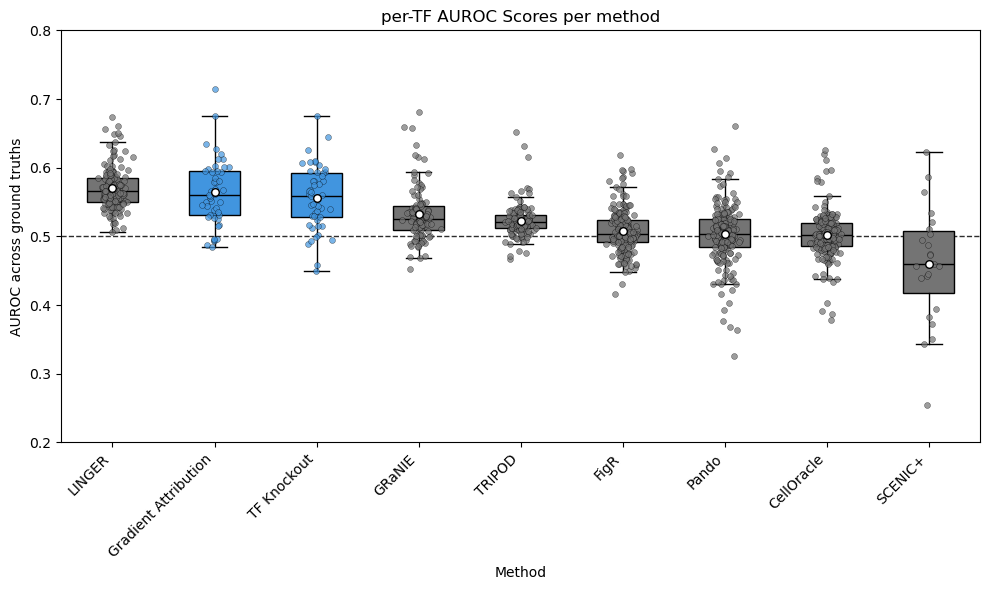

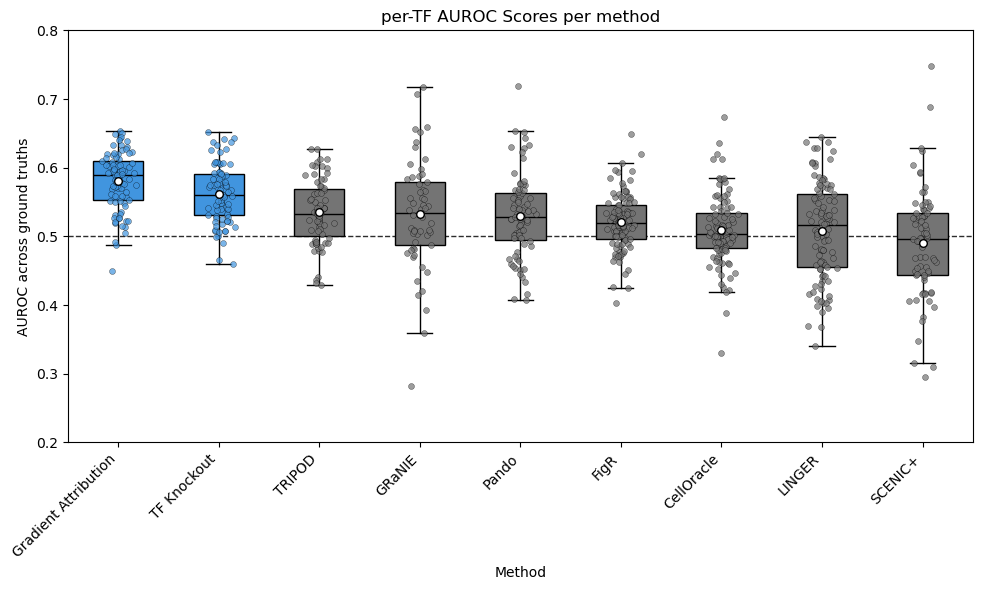

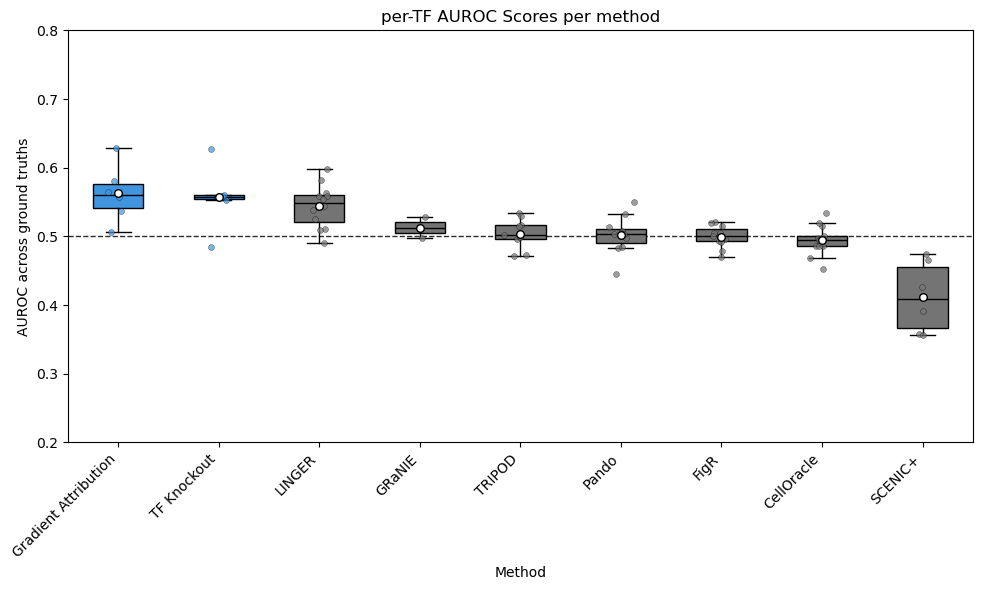

In [90]:
# Calculate and plot per-TF method rankings using different approaches
per_tf_method_three(k562_per_tf_df)
per_tf_method_three(mESC_per_tf_df)
per_tf_method_three(macrophage_per_tf_df)

## Testing K562 Stability refactored model results

In [107]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stability_boxplots_by_experiment(df, per_tf=True, method_name="Gradient Attribution"):
    # Filter to GA only
    d = df[df["method"] == method_name].copy()
    if d.empty:
        raise ValueError(f"No rows found for method '{method_name}'. Available methods: {df['method'].unique()}")

    # Order experiments as they appear (or sort)
    exp_order = list(dict.fromkeys(d["experiment"].tolist()))
    data = [d.loc[d["experiment"] == e, "auroc"].dropna().to_numpy() for e in exp_order]

    fig, ax = plt.subplots(figsize=(6.5, 5))
    ax.axhline(0.5, color="#2D2D2D", linestyle="--", linewidth=1)

    bp = ax.boxplot(
        data,
        tick_labels=exp_order,
        patch_artist=True,
        showfliers=False
    )

    # style
    for box in bp["boxes"]:
        box.set_facecolor("#4195df")
    for med in bp["medians"]:
        med.set_color("black")

    # mean markers
    for i, e in enumerate(exp_order, start=1):
        y = d.loc[d["experiment"] == e, "auroc"].dropna().to_numpy()
        if y.size == 0:
            continue

        ax.scatter(i, y.mean(), color="white", edgecolor="k",
                   s=30, zorder=4)

    ax.set_xlabel("Stability experiment")
    
    if per_tf == True:
        ax.set_ylabel("per-TF AUROC")
        ax.set_title(f"{method_name} per-TF AUROC by stability experiment")
    else:
        ax.set_ylabel("AUROC")
        ax.set_title(f"{method_name} AUROC by stability experiment")

    ax.set_ylim((0.2, 0.8) if per_tf else (0.2, 0.8))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    return fig


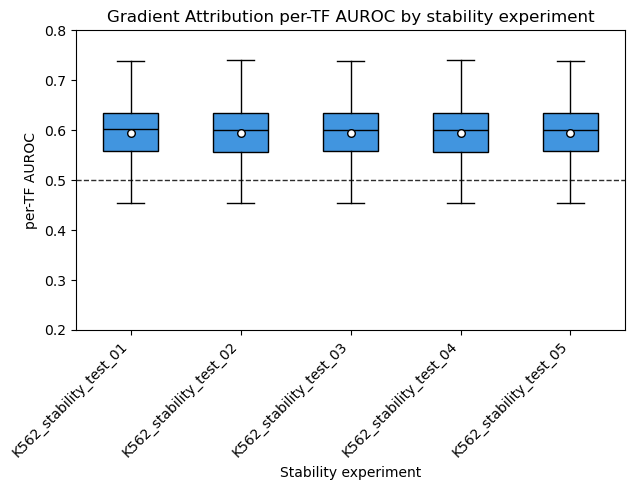

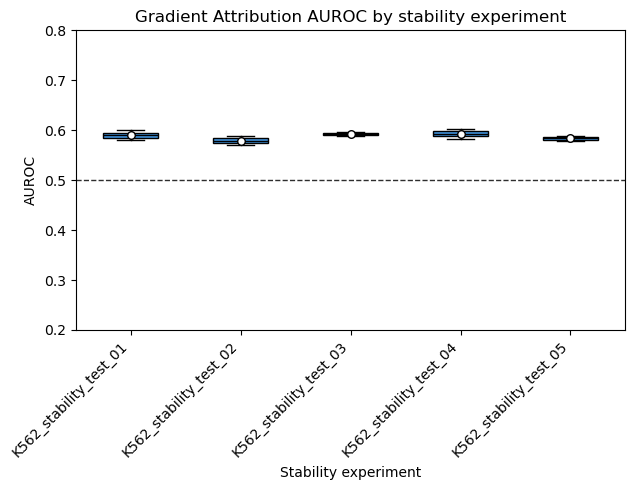

In [111]:
from sqlalchemy import all_


stability_experiments = [
    "K562_stability_test_01",
    "K562_stability_test_02",
    "K562_stability_test_03",
    "K562_stability_test_04",
    "K562_stability_test_05",
]

for stability_exp in stability_experiments:
    stability_per_tf_df, stability_per_gt_df = open_auc_data_files(stability_exp)
    
# Plotting boxplots with all stability experiments together
all_stability_per_tf_dfs = []
all_stability_per_gt_dfs = []
for stability_exp in stability_experiments:
    stability_per_tf_df, stability_per_gt_df = open_auc_data_files(stability_exp)
    stability_per_tf_df['experiment'] = stability_exp
    stability_per_gt_df['experiment'] = stability_exp
    all_stability_per_tf_dfs.append(stability_per_tf_df)
    all_stability_per_gt_dfs.append(stability_per_gt_df)
    
combined_stability_per_tf_df = pd.concat(all_stability_per_tf_dfs, ignore_index=True)
combined_stability_per_gt_df = pd.concat(all_stability_per_gt_dfs, ignore_index=True)

fig = plot_stability_boxplots_by_experiment(combined_stability_per_tf_df, method_name="Gradient Attribution", per_tf=True)
plt.show()

combined_stability_per_gt_df = combined_stability_per_gt_df.rename(columns={'name': 'method'})
fig = plot_stability_boxplots_by_experiment(combined_stability_per_gt_df, method_name="Gradient Attribution", per_tf=False)
plt.show()

## Comparing Results From HVG Filtering

In [113]:
def plot_hvg_comparison_bar(df, per_tf=False, exp_name=""):
    # Order methods by mean AUROC
    stats = (
        df.groupby("name")["auroc"]
        .agg(["mean", "std", "count"])
        .sort_values("mean", ascending=False)
    )
    stats["sem"] = stats["std"] / np.sqrt(stats["count"])

    methods = stats.index.tolist()
    means   = stats["mean"].values
    sems    = stats["sem"].values

    feature_list = [
        "Gradient Attribution",
        "TF Knockout",
        "TF-TG Embedding Similarity",
        "Shortcut Attention"
    ]

    my_color = "#4195df"
    other_color = "#747474"

    fig, ax = plt.subplots(figsize=(10, 5))

    x = np.arange(len(methods))

    # Baseline random line
    ax.axhline(0.5, color="#2D2D2D", linestyle="--", linewidth=1)

    # --- Bar plot ---
    bars = ax.bar(
        x,
        means,
        yerr=sems,
        capsize=10,
        width=0.5,
        color=my_color,
        edgecolor="black",
        linewidth=0.8,
        zorder=2,
    )
    
    for bar, method in zip(bars, methods):
        if method in feature_list:
            bar.set_facecolor(my_color)
        else:
            bar.set_facecolor(other_color)

    ax.set_xticks(x)
    ax.set_xticklabels(methods, rotation=25, ha="right")

    ax.set_xlabel("Method")
    ax.set_ylabel("AUROC across ground truths")

    if per_tf:
        ax.set_title(f"Per-TF AUROC Scores per Method - {exp_name}")
        ax.set_ylim(0.0, 1.0)
    else:
        ax.set_title(f"AUROC Scores per Method - {exp_name}")
        ax.set_ylim(0.2, 0.8)

    plt.tight_layout()
    return fig


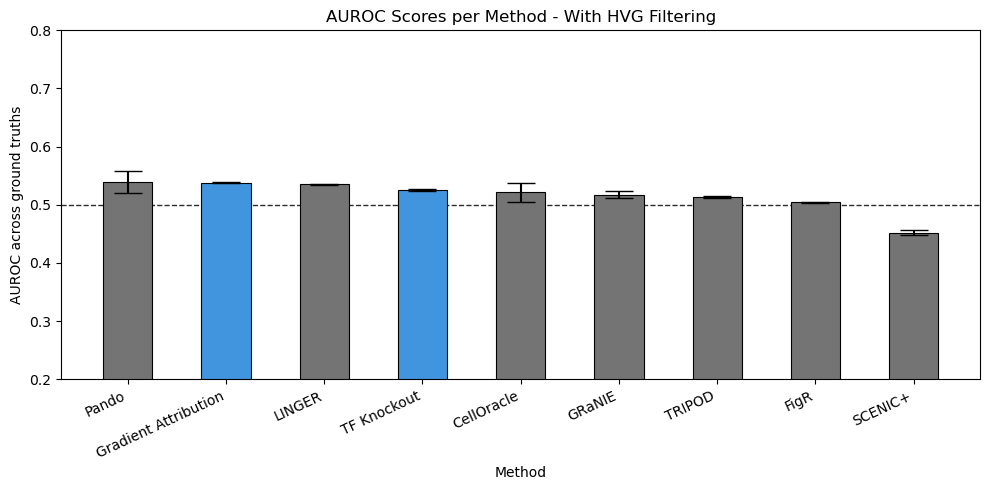

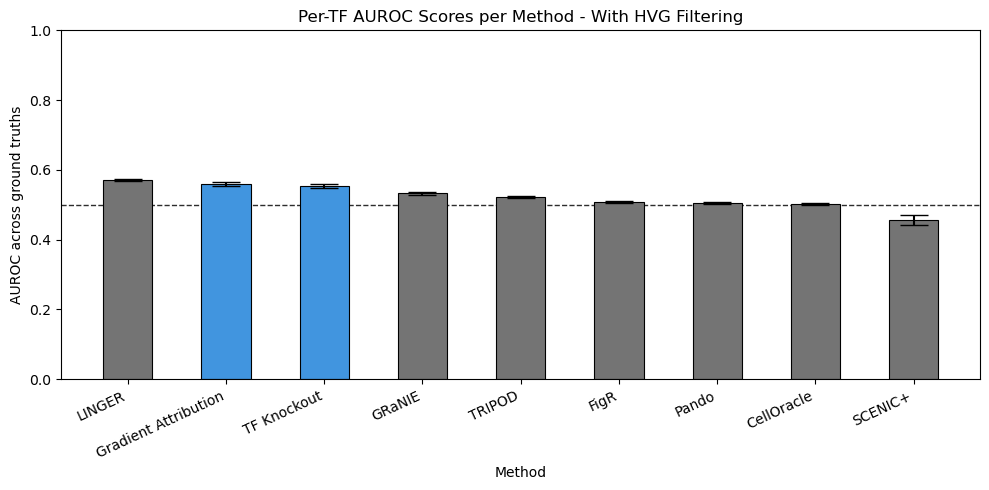

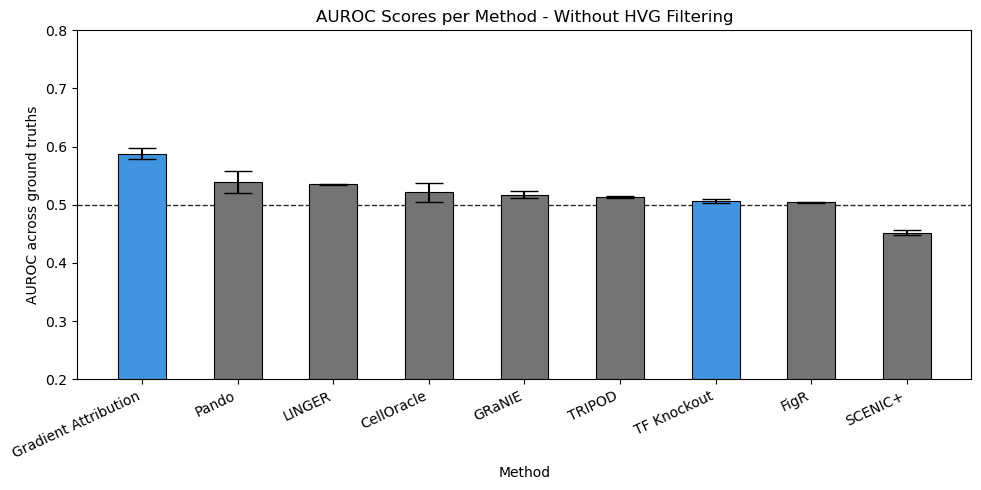

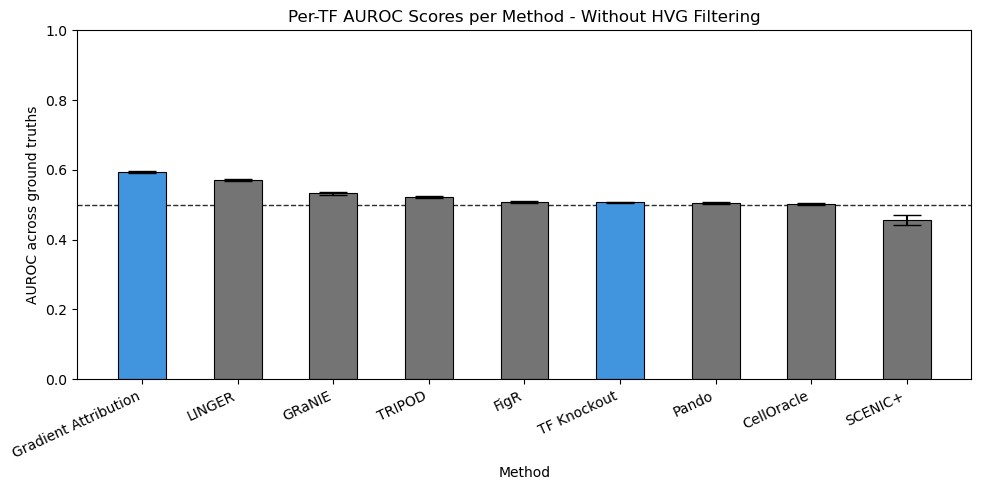

In [114]:
experiments_to_compare = {
    "With HVG Filtering": "K562_two_hops_slow_decay_long_range",
    "Without HVG Filtering": "K562_two_hops_slow_decay_long_range_no_hvg",
}

# Plotting boxplots with all stability experiments together
all_per_tf_dfs = []
all_exp_gt_dfs = []
for experiment_name, experiment in experiments_to_compare.items():
    exp_per_tf_df, exp_per_gt_df = open_auc_data_files(experiment)
    exp_per_gt_df["method"] = "Gradient Attribution"
    all_per_tf_dfs.append(exp_per_tf_df)
    all_exp_gt_dfs.append(exp_per_gt_df)
    
    fig = plot_hvg_comparison_bar(exp_per_gt_df, per_tf=False, exp_name=experiment_name)
    
    fig.show()
    
    exp_per_tf_df = exp_per_tf_df.rename(columns={'method': 'name'})
    fig = plot_hvg_comparison_bar(exp_per_tf_df, per_tf=True, exp_name=experiment_name)
    fig.show()


K562 with HVG filtering - Gradient Attribution mean AUROC: 0.538
K562 without HVG filtering - Gradient Attribution mean AUROC: 0.588


/tmp/ipykernel_2478545/2364241067.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad_attrib_k562_no_hvg["name"] = "Gradient Attribution\nNo HVG"
/tmp/ipykernel_2478545/2364241067.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad_attrib_k562_hvg["name"] = "Gradient Attribution\nWith HVG"


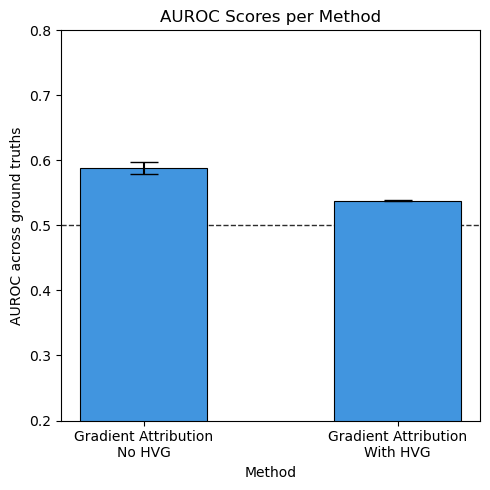

In [71]:
k562_no_hvg_mean_auroc = calculate_mean_auroc_for_method(all_exp_gt_dfs[1], "Gradient Attribution")
k562_hvg_mean_auroc = calculate_mean_auroc_for_method(all_exp_gt_dfs[0], "Gradient Attribution")
print(f"K562 with HVG filtering - Gradient Attribution mean AUROC: {k562_hvg_mean_auroc:.3f}")
print(f"K562 without HVG filtering - Gradient Attribution mean AUROC: {k562_no_hvg_mean_auroc:.3f}")

grad_attrib_k562_no_hvg = all_exp_gt_dfs[1][all_exp_gt_dfs[1]["name"] == "Gradient Attribution"]
grad_attrib_k562_no_hvg["name"] = "Gradient Attribution\nNo HVG"
grad_attrib_k562_hvg = all_exp_gt_dfs[0][all_exp_gt_dfs[0]["name"] == "Gradient Attribution"]
grad_attrib_k562_hvg["name"] = "Gradient Attribution\nWith HVG"

combined_df = pd.concat([grad_attrib_k562_no_hvg, grad_attrib_k562_hvg], ignore_index=True)
fig = plot_hvg_comparison_bar(combined_df, per_tf=False)
fig.show()

K562 with HVG filtering - Gradient Attribution per-TF AUROC: 0.564
K562 without HVG filtering - Gradient Attribution per-TF AUROC: 0.586


/tmp/ipykernel_2478545/735133391.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad_attrib_k562_no_hvg["name"] = "Gradient Attribution\nNo HVG"
/tmp/ipykernel_2478545/735133391.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grad_attrib_k562_hvg["name"] = "Gradient Attribution\nWith HVG"


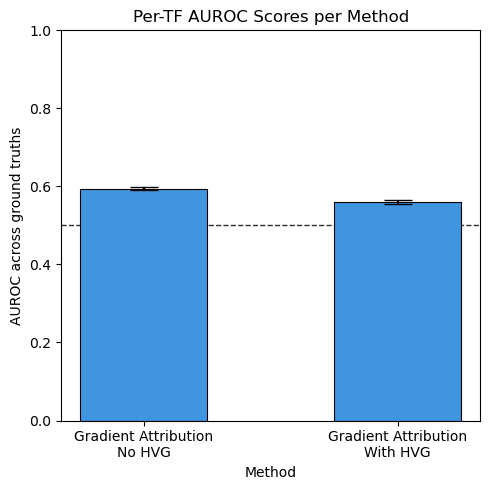

In [82]:
k562_no_hvg_mean_auroc = calculate_mean_per_tf_auroc(all_per_tf_dfs[1], "Gradient Attribution")
k562_hvg_mean_auroc = calculate_mean_per_tf_auroc(all_per_tf_dfs[0], "Gradient Attribution")
print(f"K562 with HVG filtering - Gradient Attribution per-TF AUROC: {k562_hvg_mean_auroc:.3f}")
print(f"K562 without HVG filtering - Gradient Attribution per-TF AUROC: {k562_no_hvg_mean_auroc:.3f}")

grad_attrib_k562_no_hvg = all_per_tf_dfs[1][all_per_tf_dfs[1]["method"] == "Gradient Attribution"]
grad_attrib_k562_no_hvg["name"] = "Gradient Attribution\nNo HVG"
grad_attrib_k562_hvg = all_per_tf_dfs[0][all_per_tf_dfs[0]["method"] == "Gradient Attribution"]
grad_attrib_k562_hvg["name"] = "Gradient Attribution\nWith HVG"

combined_df = pd.concat([grad_attrib_k562_no_hvg, grad_attrib_k562_hvg], ignore_index=True)
fig = plot_hvg_comparison_bar(combined_df, per_tf=True)
fig.show()

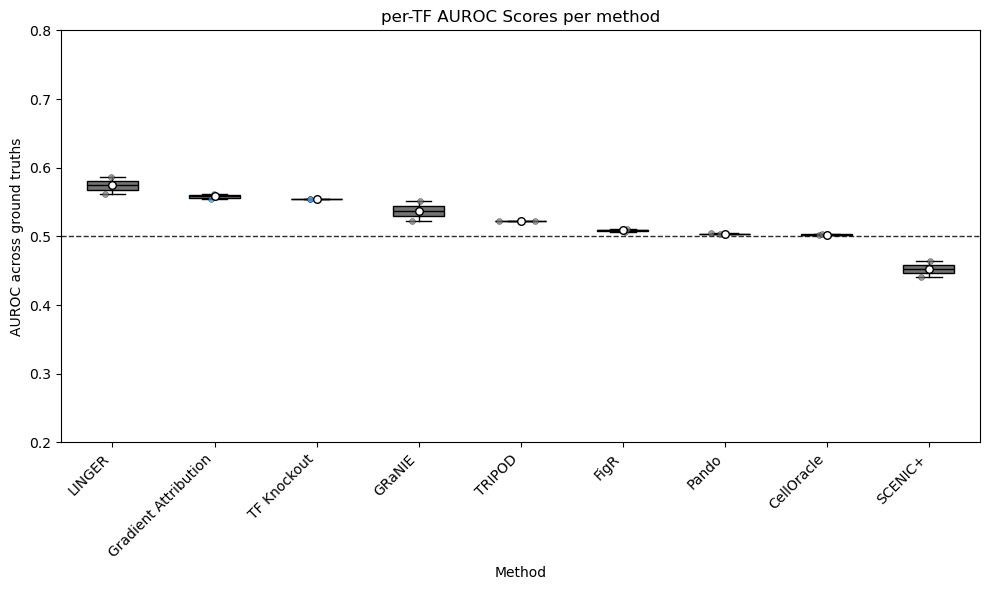

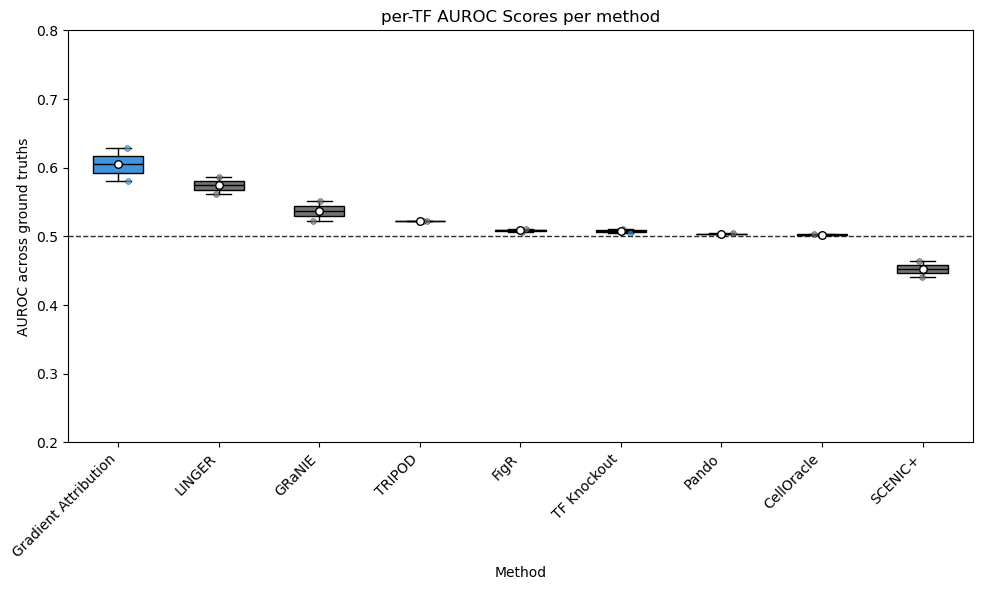

In [92]:
per_tf_method_one(all_per_tf_dfs[0])
per_tf_method_one(all_per_tf_dfs[1])

In [50]:
#!/usr/bin/env python3
"""
Analyze raw single-cell ATAC peak-count matrix stored as Parquet.

Input format:
  scATAC_seq_raw.parquet
    - index: genomic locations "chrN:start-end"
    - columns: cell barcodes
    - values: peak counts (nonnegative integers)

Outputs (in --outdir):
  - qc_summary.csv
  - peak_summary.csv
  - fragments_per_cell_hist.png
  - peaks_per_cell_hist.png
  - top_peaks_mean_counts.csv
  - top_peaks_detection_rate.csv
  - cell_by_peak_sparsity.txt
  - optional: filtered matrix (parquet) if --write_filtered
  - optional: LSI scatter plot (png) if --run_lsi (requires sklearn)

Usage:
  python atac_raw_qc.py --input scATAC_seq_raw.parquet --outdir QC_OUT --min_frags 1000 --min_peaks 500
"""

from __future__ import annotations

import argparse
import os
import re
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ---------------------------
# Helpers
# ---------------------------

LOC_RE = re.compile(r"^(chr[^:]+):(\d+)-(\d+)$")


def parse_peak_locs(index: pd.Index) -> pd.DataFrame:
    """Parse chr:start-end index into a DataFrame with chrom/start/end/width."""
    s = index.astype(str)
    m = s.str.extract(LOC_RE)
    if m.isna().any(axis=None):
        bad = s[m.isna().any(axis=1)].tolist()[:10]
        raise ValueError(
            f"Found unparseable genomic locations in index (showing up to 10): {bad}\n"
            "Expected format like 'chr1:123-456'."
        )
    out = pd.DataFrame(
        {
            "chrom": m[0].values,
            "start": m[1].astype(np.int64).values,
            "end": m[2].astype(np.int64).values,
        },
        index=index,
    )
    out["width"] = (out["end"] - out["start"]).astype(np.int64)
    return out


def safe_makedirs(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)


def save_fig(fig: plt.Figure, path: Path, dpi: int = 200) -> None:
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)


def hist_plot(values: np.ndarray, title: str, xlabel: str, outpath: Path, bins: int = 60, logx: bool = True):
    v = values[np.isfinite(values)]
    v = v[v >= 0]
    if v.size == 0:
        return

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.hist(v, bins=bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Number of cells")
    if logx:
        ax.set_xscale("log")
    ax.grid(True, alpha=0.25)
    save_fig(fig, outpath)


def downsample_columns(df: pd.DataFrame, max_cells: int, seed: int = 0) -> pd.DataFrame:
    if df.shape[1] <= max_cells:
        return df
    rng = np.random.default_rng(seed)
    keep = rng.choice(df.columns.to_numpy(), size=max_cells, replace=False)
    keep = pd.Index(keep)
    return df.loc[:, keep]


# ---------------------------
# Core QC
# ---------------------------

@dataclass
class QcThresholds:
    min_frags: int = 1000     # total counts per cell
    min_peaks: int = 500      # detected peaks per cell (nonzero)
    max_frags: int | None = None
    max_peaks: int | None = None


def compute_cell_qc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Per-cell QC:
      - fragments: sum of counts per cell
      - peaks_detected: number of nonzero peaks per cell
      - mean_count_nonzero: mean of counts among nonzero peaks
    """
    # Sum per cell (fragments proxy)
    fragments = df.sum(axis=0).astype(np.int64)

    # Peaks detected per cell
    peaks_detected = (df > 0).sum(axis=0).astype(np.int64)

    # Mean count among nonzero peaks (avoid division by zero)
    nz_sum = df.where(df > 0, 0).sum(axis=0)
    nz_n = peaks_detected.replace(0, np.nan)
    mean_count_nonzero = (nz_sum / nz_n).astype(float)

    qc = pd.DataFrame(
        {
            "fragments": fragments,
            "peaks_detected": peaks_detected,
            "mean_count_nonzero": mean_count_nonzero,
        }
    )
    return qc


def compute_peak_qc(df: pd.DataFrame, peak_locs: pd.DataFrame | None = None) -> pd.DataFrame:
    """
    Per-peak QC:
      - total_counts: sum across cells
      - detection_rate: fraction of cells with nonzero
      - mean_count: mean across cells (including zeros)
      - mean_nonzero: mean among cells where peak is nonzero
      - width: from index if provided
    """
    total_counts = df.sum(axis=1).astype(np.int64)
    detected_n = (df > 0).sum(axis=1).astype(np.int64)
    n_cells = df.shape[1]

    mean_count = (total_counts / max(n_cells, 1)).astype(float)

    nz = detected_n.replace(0, np.nan)
    mean_nonzero = (df.where(df > 0, 0).sum(axis=1) / nz).astype(float)

    out = pd.DataFrame(
        {
            "total_counts": total_counts,
            "detected_cells": detected_n,
            "detection_rate": (detected_n / max(n_cells, 1)).astype(float),
            "mean_count": mean_count,
            "mean_nonzero": mean_nonzero,
        },
        index=df.index,
    )

    if peak_locs is not None:
        out = out.join(peak_locs[["chrom", "start", "end", "width"]], how="left")

    return out


def apply_cell_filters(qc: pd.DataFrame, thr: QcThresholds) -> pd.Index:
    keep = (qc["fragments"] >= thr.min_frags) & (qc["peaks_detected"] >= thr.min_peaks)
    if thr.max_frags is not None:
        keep &= (qc["fragments"] <= thr.max_frags)
    if thr.max_peaks is not None:
        keep &= (qc["peaks_detected"] <= thr.max_peaks)
    return qc.index[keep]


def apply_peak_filters(peak_qc: pd.DataFrame, min_detection_rate: float = 0.01, min_total_counts: int = 10) -> pd.Index:
    keep = (peak_qc["detection_rate"] >= float(min_detection_rate)) & (peak_qc["total_counts"] >= int(min_total_counts))
    return peak_qc.index[keep]


# ---------------------------
# Optional LSI (TF-IDF + SVD)
# ---------------------------

def run_lsi(df: pd.DataFrame, n_components: int = 30, max_cells: int = 20000, seed: int = 0):
    """
    Simple LSI on peak x cell count matrix.
    - TF-IDF transform (peaks as terms, cells as documents)
    - Truncated SVD
    Returns: cell_embeddings (cells x n_components), sing_vals
    """
    try:
        from sklearn.decomposition import TruncatedSVD
    except Exception as e:
        raise RuntimeError("LSI requires scikit-learn (sklearn). Install it or disable --run_lsi.") from e

    # (peaks x cells) -> maybe downsample cells for speed
    X = downsample_columns(df, max_cells=max_cells, seed=seed)

    # TF: normalize by cell total
    cell_sum = X.sum(axis=0).to_numpy().astype(float)
    cell_sum[cell_sum == 0] = 1.0
    tf = X.to_numpy(dtype=float) / cell_sum[None, :]

    # IDF: inverse document frequency (per peak)
    detected = (X.to_numpy() > 0).sum(axis=1).astype(float)
    n_docs = X.shape[1]
    idf = np.log1p(n_docs / np.maximum(detected, 1.0))

    tfidf = tf * idf[:, None]

    svd = TruncatedSVD(n_components=n_components, random_state=seed)
    Z = svd.fit_transform(tfidf.T)  # cells x components
    return pd.DataFrame(Z, index=X.columns, columns=[f"LSI{i+1}" for i in range(Z.shape[1])]), svd.singular_values_


# ---------------------------
# Main
# ---------------------------
min_frags=1000
min_peaks=500

in_path = Path('/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/raw/mESC/E7.5_rep1/scATAC_seq_raw.parquet')
outdir = Path("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/atac_qc_test_out")
safe_makedirs(outdir)

# 1) Load matrix
df = pd.read_parquet(in_path).T
print(df.head())

# Ensure index is peak locs and columns are cells
if df.index.nlevels != 1:
    raise ValueError("Expected a single-level index of peak locations.")
df.index = df.index.astype(str)
df.columns = df.columns.astype(str)

# Ensure numeric
# Parquet might store ints; convert cautiously
df = df.apply(pd.to_numeric, errors="coerce")
if df.isna().any(axis=None):
    # NaNs can happen if the file has non-numeric columns; drop/raise
    n_na = int(df.isna().sum().sum())
    raise ValueError(f"Found {n_na} NaN values after numeric coercion. Check input parquet types.")

# 2) Parse peak locations
peak_locs = parse_peak_locs(df.index)

# 3) Basic global stats
n_peaks, n_cells = df.shape
nnz = int((df.to_numpy() != 0).sum())
sparsity = 1.0 - (nnz / float(n_peaks * max(n_cells, 1)))

(outdir / "cell_by_peak_sparsity.txt").write_text(
    f"peaks={n_peaks}\n"
    f"cells={n_cells}\n"
    f"nnz={nnz}\n"
    f"sparsity={sparsity:.6f}\n"
)

# 4) Per-cell QC
cell_qc = compute_cell_qc(df)
cell_qc.index.name = "cell_barcode"
cell_qc.to_csv(outdir / "qc_summary.csv")

# Plots
hist_plot(cell_qc["fragments"].to_numpy(), "Fragments per cell", "Fragments (sum of peak counts)", outdir / "fragments_per_cell_hist.png")
hist_plot(cell_qc["peaks_detected"].to_numpy(), "Peaks detected per cell", "Detected peaks (# nonzero)", outdir / "peaks_per_cell_hist.png")

# 5) Per-peak QC
peak_qc = compute_peak_qc(df, peak_locs=peak_locs)
peak_qc.index.name = "peak"
peak_qc.to_csv(outdir / "peak_summary.csv")

# Top peaks tables
peak_qc.sort_values("mean_count", ascending=False).head(200).to_csv(outdir / "top_peaks_mean_counts.csv")
peak_qc.sort_values("detection_rate", ascending=False).head(200).to_csv(outdir / "top_peaks_detection_rate.csv")

# 6) Filtering
thr = QcThresholds(
    min_frags=min_frags,
    min_peaks=min_peaks,
    max_frags=None,
    max_peaks=None,
)
keep_cells = apply_cell_filters(cell_qc, thr)

keep_peaks = apply_peak_filters(
    peak_qc,
    min_detection_rate=0.01,
    min_total_counts=10,
)

df_filt = df.loc[keep_peaks, keep_cells]

# Save a small filter summary
summary = {
    "input_peaks": n_peaks,
    "input_cells": n_cells,
    "kept_peaks": int(df_filt.shape[0]),
    "kept_cells": int(df_filt.shape[1]),
    "min_frags": min_frags,
    "min_peaks": min_peaks,
    "min_peak_detection_rate": 0.01,
    "min_peak_total_counts": 10,
}
pd.Series(summary).to_csv(outdir / "filter_summary.csv", header=False)

# 7) Optional LSI embedding + plot
Z, svals = run_lsi(
    df_filt,
    n_components=10,
    max_cells=10000,
    seed=42,
)
Z.to_csv(outdir / "lsi_cell_embeddings.csv")
pd.Series(svals, index=[f"s{i+1}" for i in range(len(svals))]).to_csv(outdir / "lsi_singular_values.csv")

# plot LSI1 vs LSI2
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(Z["LSI1"].to_numpy(), Z["LSI2"].to_numpy(), s=3, alpha=0.6)
ax.set_title("LSI (TF-IDF + SVD) on filtered scATAC")
ax.set_xlabel("LSI1")
ax.set_ylabel("LSI2")
ax.grid(True, alpha=0.25)
save_fig(fig, outdir / "lsi_scatter.png")

print(f"[done] wrote outputs to: {outdir}")



[done] wrote outputs to: /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/atac_qc_test_out
